# Home Price Prediction Model

In [2]:
import pandas as pd
import numpy as numpy
import seaborn as sns
from prophet import Prophet
sns.set_style('darkgrid')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Goal: Create a forecast of home prices using machine learning algorythms.
- V1 will be done using [Prophet](https://pypi.org/project/prophet/)

## Data


### Recessions

[Real-time Sahm Rule Recession Indicator](https://fred.stlouisfed.org/series/SAHMREALTIME)

Sahm Recession Indicator signals the start of a recession when the three-month moving average of the national unemployment rate (U3) rises by 0.50 percentage points or more relative to the minimum of the three-month averages from the previous 12 months.

In [3]:
df_sahm = pd.read_csv('SAHMREALTIME.csv')
df_sahm.head()


,DATE,SAHMREALTIME
0,1959-12-01,0.77
1,1960-01-01,0.50
2,1960-02-01,0.13
3,1960-03-01,0.10
4,1960-04-01,0.03


In [4]:
df_sahm.tail()

,DATE,SAHMREALTIME
764,2023-08-01,0.13
765,2023-09-01,0.20
766,2023-10-01,0.33
767,2023-11-01,0.30
768,2023-12-01,0.23


In [5]:
df_sahm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          769 non-null    object 
 1   SAHMREALTIME  769 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.1+ KB


### Interest Rates

[Federal Funds Effective Rate](https://fred.stlouisfed.org/series/FEDFUNDS)

The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. The federal funds rate is the central interest rate in the U.S. financial market. It influences other interest rates such as the prime rate, which is the rate banks charge their customers with higher credit ratings. Additionally, the federal funds rate indirectly influences longer- term interest rates such as mortgages, loans, and savings, all of which are very important to consumer wealth and confidence. 

In [6]:
df_fed = pd.read_csv('FEDFUNDS.csv')
df_fed.head()


,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [7]:
df_fed.tail()

,DATE,FEDFUNDS
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33
833,2023-12-01,5.33


In [8]:
df_fed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      834 non-null    object 
 1   FEDFUNDS  834 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


### Housing Prices

[S&P CoreLogic Case-Shiller U.S. National Home Price Index](https://fred.stlouisfed.org/series/CSUSHPINSA)
The S&P CoreLogic Case-Shiller Home Price Indices are calculated monthly using a three-month moving average. Index levels are published with a two-month lag and are released at 9 am EST on the last Tuesday of every month. Index performance is based on non-seasonally adjusted data.


In [9]:
df_csus = pd.read_csv('CSUSHPINSA.csv')
df_csus.head()

,DATE,CSUSHPINSA
0,1987-01-01,63.735
1,1987-02-01,64.134
2,1987-03-01,64.470
3,1987-04-01,64.973
4,1987-05-01,65.547


In [10]:
df_csus.tail()

,DATE,CSUSHPINSA
437,2023-06-01,308.285
438,2023-07-01,310.146
439,2023-08-01,311.519
440,2023-09-01,312.417
441,2023-10-01,312.953


In [11]:
df_csus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        442 non-null    object 
 1   CSUSHPINSA  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


#### Observations

- Each data set contains a different number of rows
- They all have a different start date
- fed & sahm have same end dates; csus has a different end date
- They all are monthly
- There are no null values

#### Recommendations

- Trim the data sets so they all have matching start and end dates in order to concatenate them using date as the common value

## Data Wrangling

- Trim all data sets to common start date of 1987-01-01 and end date of 2023-10-01
- Concatenate data with DATE as the common column

### Trim sahm

In [12]:
display(df_sahm.iloc[325])

DATE            1987-01-01
SAHMREALTIME         -0.07
Name: 325, dtype: object

In [13]:
df_sahm[df_sahm['DATE']=='1987-01-01'].index

Index([325], dtype='int64')

In [14]:
display(df_sahm.iloc[766])

DATE            2023-10-01
SAHMREALTIME          0.33
Name: 766, dtype: object

In [15]:
df_sahm_trim = df_sahm.loc[325:766]

df_sahm_trim

,DATE,SAHMREALTIME
325,1987-01-01,-0.07
326,1987-02-01,-0.07
327,1987-03-01,-0.03
328,1987-04-01,-0.13
329,1987-05-01,-0.13
...,...,...
762,2023-06-01,0.07
763,2023-07-01,0.10
764,2023-08-01,0.13
765,2023-09-01,0.20


In [16]:
df_sahm_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 325 to 766
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          442 non-null    object 
 1   SAHMREALTIME  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


### Trim Fed



In [17]:
# find location of start date
display(df_fed.iloc[390])


DATE        1987-01-01
FEDFUNDS          6.43
Name: 390, dtype: object

In [18]:
display(df_fed.iloc[390])

DATE        1987-01-01
FEDFUNDS          6.43
Name: 390, dtype: object

In [19]:
df_fed_trim = df_fed.loc[390:831]

df_fed_trim

,DATE,FEDFUNDS
390,1987-01-01,6.43
391,1987-02-01,6.10
392,1987-03-01,6.13
393,1987-04-01,6.37
394,1987-05-01,6.85
...,...,...
827,2023-06-01,5.08
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33


In [20]:
df_fed_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 390 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      442 non-null    object 
 1   FEDFUNDS  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


### Join Data

In [21]:
combined_data_01 = pd.merge(df_csus, df_fed, how='inner', on='DATE') 
combined_data_01.head()

,DATE,CSUSHPINSA,FEDFUNDS
0,1987-01-01,63.735,6.43
1,1987-02-01,64.134,6.10
2,1987-03-01,64.470,6.13
3,1987-04-01,64.973,6.37
4,1987-05-01,65.547,6.85


In [22]:
combined_data_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        442 non-null    object 
 1   CSUSHPINSA  442 non-null    float64
 2   FEDFUNDS    442 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.5+ KB


In [23]:
combined_data_02 = pd.merge(combined_data_01, df_sahm, how='inner', on='DATE') 
combined_data_02.head()


,DATE,CSUSHPINSA,FEDFUNDS,SAHMREALTIME
0,1987-01-01,63.735,6.43,-0.07
1,1987-02-01,64.134,6.10,-0.07
2,1987-03-01,64.470,6.13,-0.03
3,1987-04-01,64.973,6.37,-0.13
4,1987-05-01,65.547,6.85,-0.13


<Axes: >

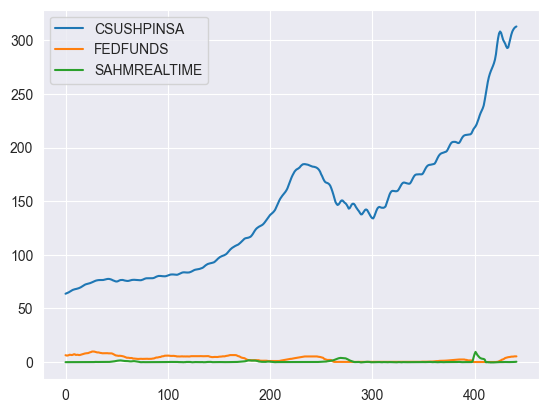

In [24]:
# visualize combined data

combined_data_02.plot(kind='line')

### Feature Engineering



In [25]:
# combined_data_02['DATE'] = pd.to_str(combined_data_02['DATE'], 
 # format = '%Y-%m-%d', 
 # errors = 'coerce')

In [26]:
combined_data_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          442 non-null    object 
 1   CSUSHPINSA    442 non-null    float64
 2   FEDFUNDS      442 non-null    float64
 3   SAHMREALTIME  442 non-null    float64
dtypes: float64(3), object(1)
memory usage: 13.9+ KB


In [27]:
# create seperate columns for data & year

combined_data_02['YEAR']= combined_data_02['DATE'].str[0:4]
combined_data_02['YEAR']

0      1987
1      1987
2      1987
3      1987
4      1987
       ... 
437    2023
438    2023
439    2023
440    2023
441    2023
Name: YEAR, Length: 442, dtype: object

In [28]:
combined_data_02['MONTH']= combined_data_02['DATE'].str[5:7]
combined_data_02['MONTH']

0      01
1      02
2      03
3      04
4      05
       ..
437    06
438    07
439    08
440    09
441    10
Name: MONTH, Length: 442, dtype: object

In [29]:
combined_data_02

,DATE,CSUSHPINSA,FEDFUNDS,SAHMREALTIME,YEAR,MONTH
0,1987-01-01,63.735,6.43,-0.07,1987,01
1,1987-02-01,64.134,6.10,-0.07,1987,02
2,1987-03-01,64.470,6.13,-0.03,1987,03
3,1987-04-01,64.973,6.37,-0.13,1987,04
4,1987-05-01,65.547,6.85,-0.13,1987,05
...,...,...,...,...,...,...
437,2023-06-01,308.285,5.08,0.07,2023,06
438,2023-07-01,310.146,5.12,0.10,2023,07
439,2023-08-01,311.519,5.33,0.13,2023,08
440,2023-09-01,312.417,5.33,0.20,2023,09


In [30]:
# Rename columns to ds & y for Prophet
combined_data_02 = combined_data_02.rename(columns={'DATE': 'ds', 'CSUSHPINSA': 'y'})
combined_data_02

,ds,y,FEDFUNDS,SAHMREALTIME,YEAR,MONTH
0,1987-01-01,63.735,6.43,-0.07,1987,01
1,1987-02-01,64.134,6.10,-0.07,1987,02
2,1987-03-01,64.470,6.13,-0.03,1987,03
3,1987-04-01,64.973,6.37,-0.13,1987,04
4,1987-05-01,65.547,6.85,-0.13,1987,05
...,...,...,...,...,...,...
437,2023-06-01,308.285,5.08,0.07,2023,06
438,2023-07-01,310.146,5.12,0.10,2023,07
439,2023-08-01,311.519,5.33,0.13,2023,08
440,2023-09-01,312.417,5.33,0.20,2023,09


In [31]:
prophet_m = Prophet()
prophet_m.fit(combined_data_02)

13:50:06 - cmdstanpy - INFO - Chain [1] start processing
13:50:06 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
future = prophet_m.make_future_dataframe(periods=365)
future.tail()

,ds
802,2024-09-26
803,2024-09-27
804,2024-09-28
805,2024-09-29
806,2024-09-30


In [36]:
forecast = prophet_m.predict(future)
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_df.tail()


,ds,yhat,yhat_lower,yhat_upper
802,2024-09-26,325.233970,316.156333,334.476657
803,2024-09-27,324.437113,315.324599,333.881784
804,2024-09-28,323.555563,313.734373,332.131965
805,2024-09-29,322.609472,312.647058,331.741065
806,2024-09-30,321.620766,312.738385,330.845469


<Axes: xlabel='ds'>

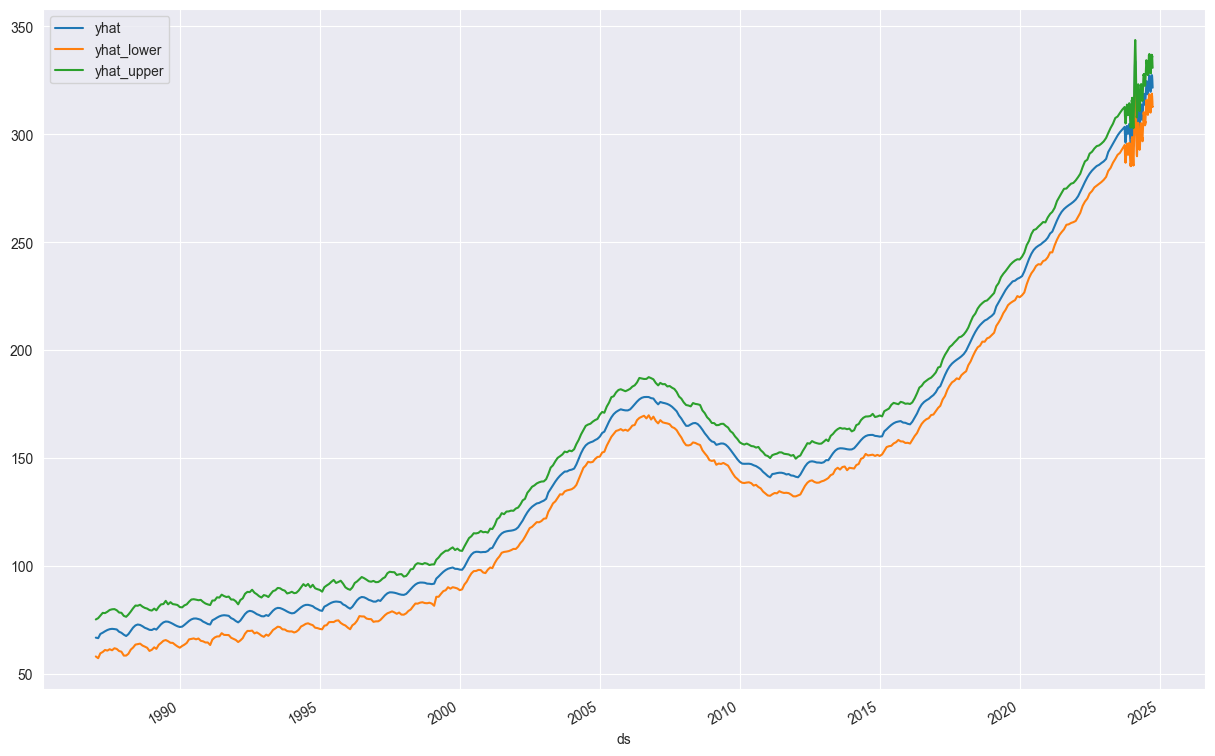

In [44]:
# Visualize the forecast

forecast_df.plot(kind='line', x='ds', y=['yhat', 'yhat_lower', 'yhat_upper'], figsize=(15,10))

### Observation

- The model is predicting conintued growth of home prices in the next 365 days
- It would be helpful to work witha model that considers other factors like interest rates and unemployment rates.

## Future Iterations

- Add wage data (needs to be transformed from quarterly to monthly to match other datasets)
- Use time series models, find model that can consider other factors like wages, interest rates and unemployment data, consider options:
    - [Exponential Smoothing](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
 

